# Clean Users Analysis

Users are scraped using the `baseline-user-ids.json` input (a list of User IDs) in `twitter_scraper.scrape` - at this point, Users' locations aren't restricted to Croatia only as they will be filtered using the `twitter_scraper.clean` module.

This module reads the scraped User data and filters it by:

* *protected* = False
* *is_croatian* = True
* *statuses_count* > 10
* *friends_count* > 10
* *friends_count* < 5000
* *followers_count* > 10
* *followers_count* < 5000

Resulting with the following data schema:

Column           | Description                                                          | Data Type   
---------------- | -------------------------------------------------------------------- | ------- 
user_id          | Numeric user identifier                                              | int64
created_at       | The UTC datetime that the user account was created on Twitter        | datetime64[ns, UTC]
screen_name      | Alphabetic user identifier                                           | string  
location         | User submitted location                                              | string  
description      | User submitted description                                           | string  
protected        | User allows public access to his profile                             | boolean 
verified         | User is verified by Twitter ([Verified Accounts](https://help.twitter.com/en/managing-your-account/about-twitter-verified-accounts))                                                       | boolean 
followers_count  | Number of accounts that follow the user                              | int64   
friends_count    | Number of accounts that the user follows                             | int64   
listed_count     | Number of public lists that this user is a member of                 | int64   
favourites_count | The number of Tweets this user has liked in the account's lifetime   | int64   
statuses_count   | The number of Tweets (including retweets) issued by the user         | int64   
is_croatian      | Custom value indicating the user's location is Croatian              | bool    
clean_location   | Custom value, aims to pinpoint a Croatian location                   | string  

## Interpreting Croatian Twitter Users

The "Clean Users Analysis" answers the following questions:

* What is the most common Croatian Users location?
* Who are Croatian Users that tweet the most (all-time number of tweets)? Are they verified?
* Which Croatian users are followed the most? 
* Which Croatian users like other tweets the most?

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.style

mpl.style.use('seaborn-v0_8-darkgrid')
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
from preproc import ANALYSIS_COLUMNS

import datetime as dt
import pandas as pd

USER_DISPLAY_NAME = 'screen_name'
ANALYSIS_START_DATE = dt.datetime.fromisoformat('2022-11-01T00:00:00+00:00')
ANALYSIS_END_DATE = dt.datetime.fromisoformat('2022-11-30T23:59:59+00:00')

users_df = pd.read_csv('preproc_users_view.csv')
tweets_view = pd.read_csv('preproc_tweets_view.csv', parse_dates=['created_at'])
tweets_view = tweets_view[
    (tweets_view.created_at >= ANALYSIS_START_DATE)
    & (tweets_view.created_at <= ANALYSIS_END_DATE)
]

users_view = users_df[users_df.user_id.isin(tweets_view.user_id.unique())].copy()
users_view = users_view[ANALYSIS_COLUMNS['users']]

users_view['hashtags'] = users_view['hashtags'].map(eval)
users_view['original_hashtags'] = users_view['original_hashtags'].map(eval)
users_view['retweet_hashtags'] = users_view['retweet_hashtags'].map(eval)
users_view['quote_hashtags'] = users_view['quote_hashtags'].map(eval)

users_view['user_mentions'] = users_view['user_mentions'].map(eval)
users_view['original_user_mentions'] = users_view['original_user_mentions'].map(eval)
users_view['retweet_user_mentions'] = users_view['retweet_user_mentions'].map(eval)
users_view['quote_user_mentions'] = users_view['quote_user_mentions'].map(eval)

stats_df = pd.DataFrame(
    [
        '{:,}'.format(len(users_df[users_df.is_croatian == True])),
        '{:,}'.format(len(tweets_view.user_id.unique())),
        '{:,}'.format(len(tweets_view)),
        
        '{0:.2f}%'.format(users_view['original_tweets_pct'].mean()*100),
        '{0:.2f}%'.format(users_view['out_retweets_pct'].mean()*100),
        '{:,}'.format(users_view['out_replies_cnt'].sum()),
        '{:,}'.format(users_view['out_quotes_cnt'].sum()),
        
        tweets_view.created_at.min(),
        tweets_view.created_at.max()

    ],
    index=[
        "Croatian Users (global) #",
        "Croatian Users (tweets) #",
        "Tweets #",
        
        "Original %",
        "Reweets %",
        "Replies #",
        "Quotes #",
        
        "Earliest Tweet date",
        "Latest Tweet date"
    ],
    columns=['Tweets Data']
)

stats_df

,Tweets Data
Croatian Users (global) #,"32,328"
Croatian Users (tweets) #,"6,608"
Tweets #,"367,262"
Original %,70.60%
Reweets %,29.40%
Replies #,"351,980.0"
Quotes #,"53,693.0"
Earliest Tweet date,2022-11-01 00:00:12+00:00
Latest Tweet date,2022-11-30 23:59:52+00:00


In [4]:
users_view[
    (users_view['screen_name'] == 'HNS_CFF')
].iloc[0]

user_id                                                               790921536
screen_name                                                             HNS_CFF
name                                                                        HNS
verified                                                                   True
location                                                     Hrvatska | Croatia
clean_location                                                         Hrvatska
description                   Službeni Twitter profil Hrvatskog nogometnog s...
is_croatian                                                                True
followers_count                                                          253625
friends_count                                                               117
favourites_count                                                            476
total_out_tweets_cnt                                                      613.0
out_retweets_cnt                        

In [5]:
import numpy as np

def df_format_decimal(df):
    format_df = df.copy()
    for col_name in df.columns:
        format_df.loc[:, col_name] = format_df[col_name].transform(lambda x: '{0:,}'.format(x))
    return format_df

df_format_decimal(users_view.set_index('user_id').select_dtypes(include=np.number).describe(percentiles=[.3, .6, .9]).transpose().round(2))# .style.to_latex(open('descriptive-statistics.tex', 'w'))

,count,mean,std,min,30%,50%,60%,90%,max
followers_count,"6,608.0","1,460.28","21,655.7",11.0,72.0,180.0,275.2,"1,724.6","1,541,746.0"
friends_count,"6,608.0",569.74,743.41,11.0,169.0,313.0,413.0,"1,341.3","4,993.0"
favourites_count,"6,608.0","13,128.62","35,426.51",0.0,656.1,"2,259.0","3,987.0","32,227.6","832,761.0"
total_out_tweets_cnt,"6,608.0",125.6,351.59,1.0,6.0,18.0,31.0,295.0,"3,790.0"
out_retweets_cnt,"6,608.0",39.04,189.7,0.0,0.0,2.0,4.0,60.0,"3,786.0"
out_retweets_pct,"6,608.0",0.29,0.35,0.0,0.0,0.12,0.25,0.96,1.0
out_replies_cnt,"6,608.0",53.27,193.34,0.0,1.0,3.0,6.0,114.0,"3,513.0"
out_replies_pct,"6,608.0",0.36,0.36,0.0,0.01,0.27,0.44,0.95,1.0
out_quotes_cnt,"6,608.0",8.13,44.29,0.0,0.0,0.0,1.0,13.0,"1,316.0"
out_quotes_pct,"6,608.0",0.05,0.12,0.0,0.0,0.0,0.01,0.16,1.0


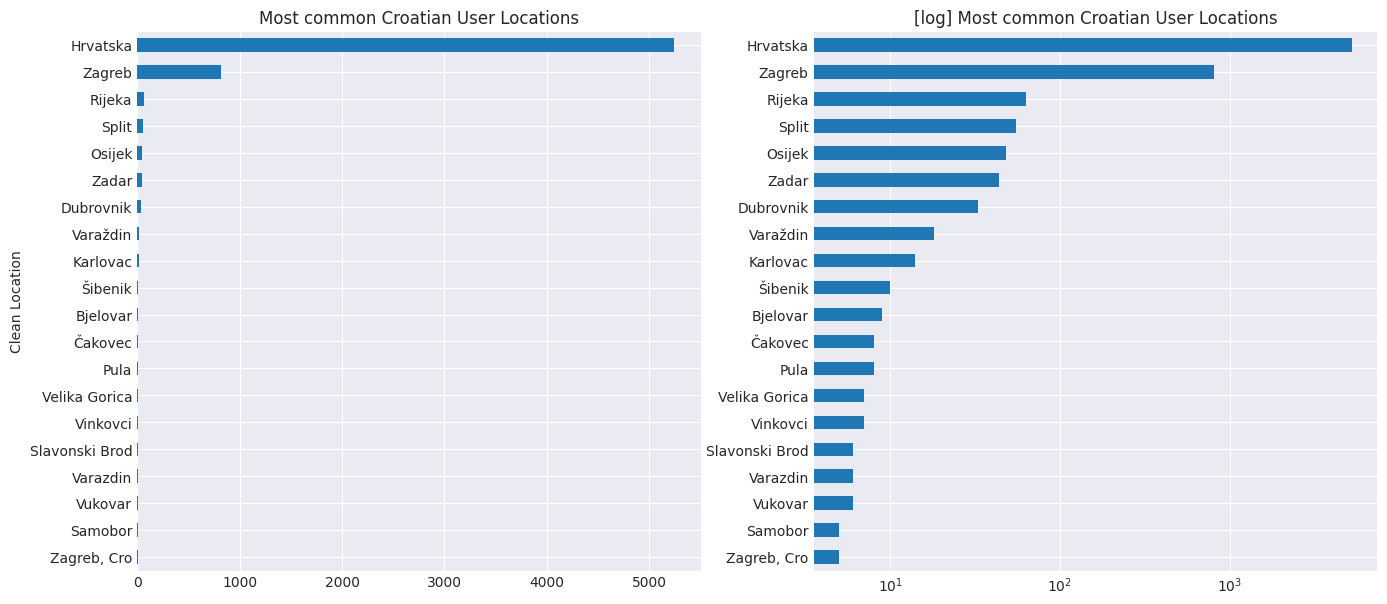

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

location_df = users_view.groupby('clean_location').size().sort_values()
# location_df.drop(['Hrvatska', '🇭🇷', 'Zg'], inplace=True)
location_df.tail(20).plot.barh(ax=axs[0])

axs[0].set_title('Most common Croatian User Locations')
axs[0].set_ylabel('Clean Location')

location_df.tail(20).plot.barh(ax=axs[1])

axs[1].set_title('[log] Most common Croatian User Locations')
axs[1].set_ylabel(None)
axs[1].set_xscale('log')
plt.show()

In [7]:
import warnings
warnings.simplefilter(action = "ignore", category = UserWarning)


PLOT_CONFIG = {
    'plot_head': 12,
    'positive_cols': {
        'in_retweets_cnt': 'Retweeted', 
        'in_replies_cnt': 'Replied', 
        'in_quotes_cnt': 'Quoted'
    },
    'negative_cols': {
        'out_retweets_cnt': 'Retweet', 
        'out_replies_cnt': 'Reply', 
        'out_quotes_cnt': 'Quote',
        'original_tweets_cnt': 'Original'
    },
    'other_cols': {
        'total_out_tweets_cnt': 'Total num. of Tweets',
        'total_in_tweets_cnt': 'Total num. of Interactions'
    }
}

rename_map = dict(PLOT_CONFIG['positive_cols'], **PLOT_CONFIG['negative_cols'])

def plot_top_tweet_users(df, title, max_x, export_plot_name=None):
    fig, ax = plt.subplots(1, figsize=(14, 8))

    top_tweets_df = df[
        ['followers_count', 'description', 'original_tweets_cnt', 
         'out_retweets_cnt', 'out_replies_cnt', 'out_quotes_cnt', 
         'in_retweets_cnt', 'in_replies_cnt', 'in_quotes_cnt' ]
    ].copy()

    top_tweets_df['original_tweets_cnt'] = top_tweets_df['original_tweets_cnt'] * -1
    top_tweets_df['out_retweets_cnt'] = top_tweets_df['out_retweets_cnt'] * -1
    top_tweets_df['out_replies_cnt'] = top_tweets_df['out_replies_cnt'] * -1
    top_tweets_df['out_quotes_cnt'] = top_tweets_df['out_quotes_cnt'] * -1
    
    top_tweets_df = top_tweets_df.rename(columns=rename_map)
    
    x1000 = max_x % 1000
    max_x = ((max_x-x1000) // 1000) * 1000 + 1000
    min_x = max_x * -1
    
    positive_cols = PLOT_CONFIG['positive_cols'].values()
    negative_cols = PLOT_CONFIG['negative_cols'].values()
    
    top_tweets_df[negative_cols].plot.barh(
        ax=ax, 
        alpha=0.5,
        stacked=True,
        color={
            'Original': default_colors[0], 
            'Retweet': default_colors[1], 
            'Reply': default_colors[2], 
            'Quote': default_colors[3]
        }
    )
    legend_1 = plt.legend(negative_cols, loc='upper left')
    for i, color in enumerate(default_colors[1:len(negative_cols)]):
        legend_1.legendHandles[i].set_color(color)
    legend_1.legendHandles[i+1].set_color(default_colors[0])


    top_tweets_df[positive_cols].plot.barh(
        ax=ax,
        stacked=True,
        color={
            'Retweeted': default_colors[1], 
            'Replied': default_colors[2], 
            'Quoted': default_colors[3]
        }
    )
    legend_2 = plt.legend(positive_cols, loc='upper right')
    for i, color in enumerate(default_colors[1:len(positive_cols)+1]):
        legend_2.legendHandles[i].set_color(color)
    
    ax.add_artist(legend_1)
    ax.add_artist(legend_2)
    ax.set_xlim(min_x, max_x)
    ax.set_title(title)
    ax.set_xlabel('Tweet Count')
    
    if USER_DISPLAY_NAME == 'screen_name':
        ax.set_ylabel('User Name')
    else:
        ax.set_ylabel('User ID')
    
    ticks = ax.get_xticks()
    ax.set_xticklabels([int(abs(tick)) for tick in ticks])
    ax.axvline(color='red')
    
    # plt.xticks(rotation=30)
    
    if export_plot_name:
        plt.savefig(export_plot_name, format='eps', papertype='a4', dpi=200)
    
    plt.show()
    

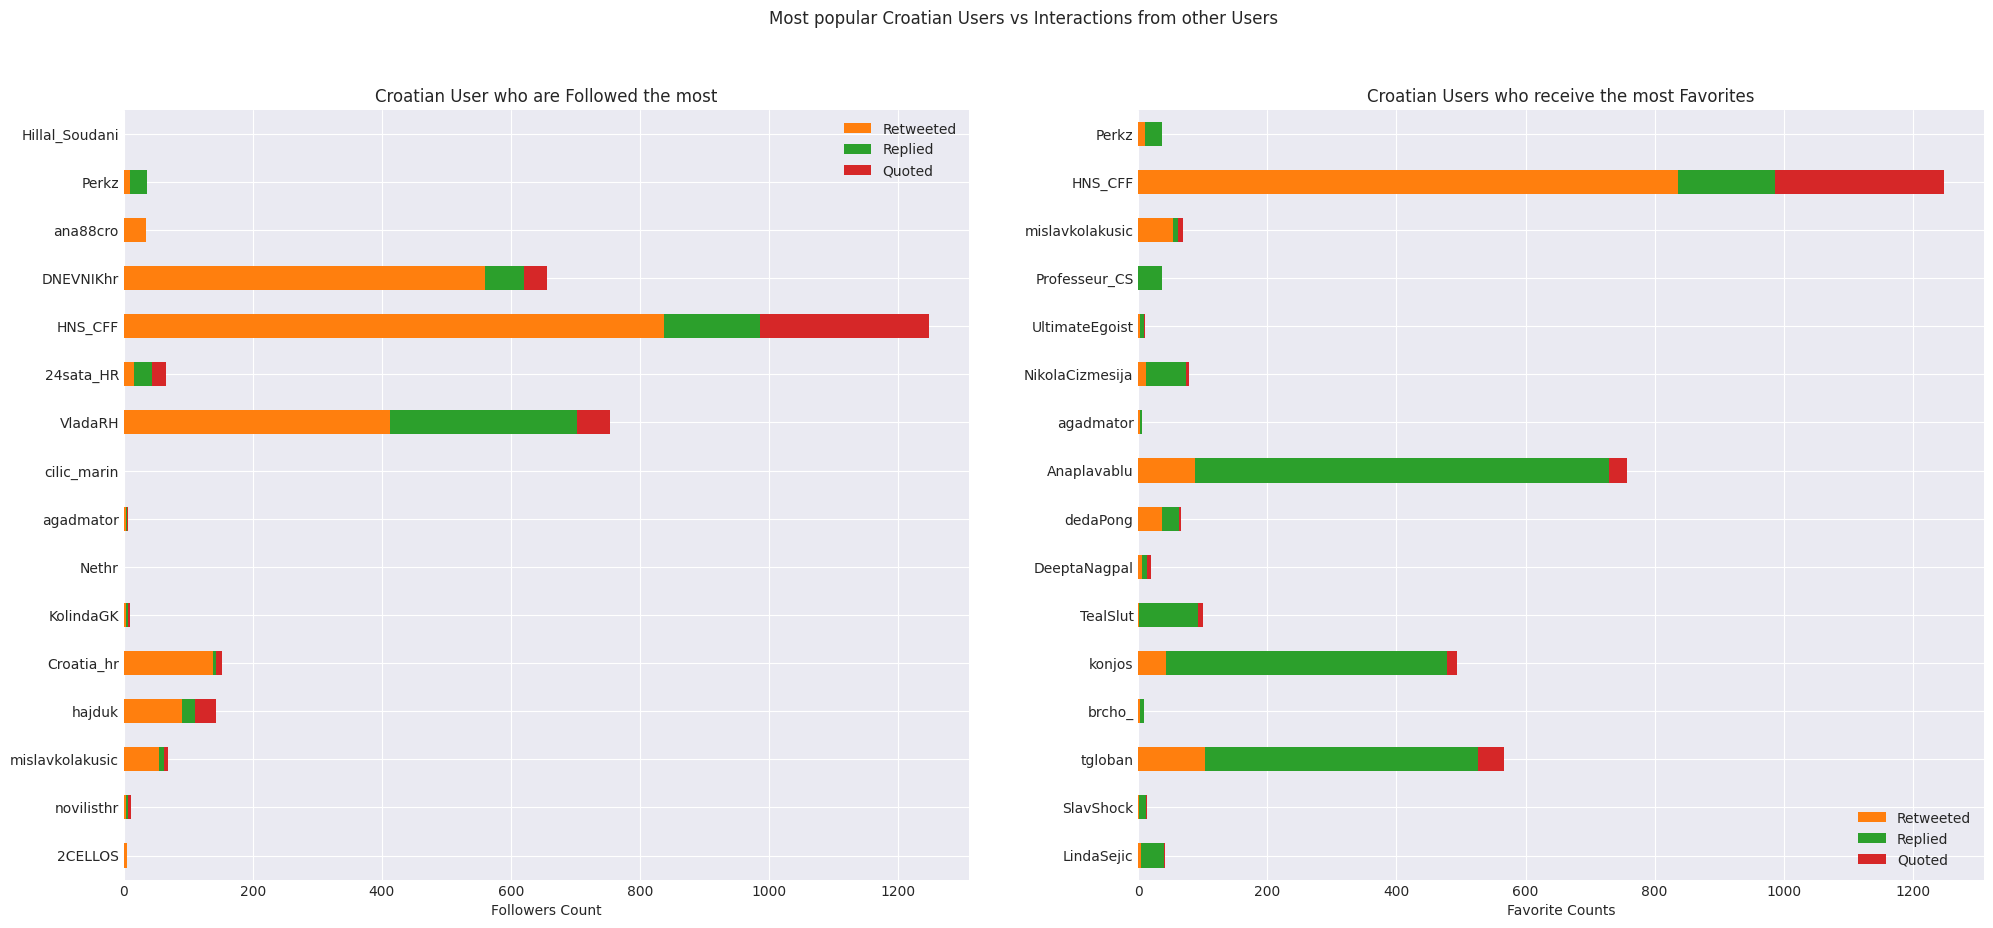

,name,description
screen_name,,
Hillal_Soudani,Hillal Soudani,Professional Footballer 2️⃣- Currently playing...
Perkz,Luka,🇭🇷\n24 years old. Professional League of Legen...
ana88cro,✨ ANA ✨,🔞ADULT ONLY 🔞
DNEVNIKhr,DNEVNIK.hr,Saznajte prvi najvažnije informacije #dnevnikhr
HNS_CFF,HNS,Službeni Twitter profil Hrvatskog nogometnog s...
24sata_HR,24sata,dnevna doza tweetova s našeg portala
VladaRH,Vlada Republike Hrvatske,Vlada Republike Hrvatske - službeni Twitter ra...
cilic_marin,Marin Cilic,Professional tennis player 🎾
agadmator,agadmator,Owner and content creator of agadmator's Chess...


In [8]:
top = 16

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))

plt.suptitle('Most popular Croatian Users vs Interactions from other Users')

top_followed_users = users_view[[USER_DISPLAY_NAME, 'name', 'description', 'followers_count', 'in_retweets_cnt', 'in_replies_cnt', 'in_quotes_cnt']] \
  .set_index(USER_DISPLAY_NAME).sort_values(by='followers_count', ascending=True).tail(top)

top_followed_users[
  ['in_retweets_cnt', 'in_replies_cnt', 'in_quotes_cnt']
].rename(
  columns=rename_map
).plot.barh(
  ax=ax[0], 
  stacked=True, 
  color={
    'Retweeted': default_colors[1], 
    'Replied': default_colors[2], 
    'Quoted': default_colors[3]
})

ax[0].set_title('Croatian User who are Followed the most')
ax[0].set_xlabel('Followers Count')
ax[0].set_ylabel(None)

top_in_favorite_cnt_users = users_view[[USER_DISPLAY_NAME, 'name', 'description', 'in_original_favorite_cnt', 'in_retweets_cnt', 'in_replies_cnt', 'in_quotes_cnt']] \
  .set_index(USER_DISPLAY_NAME).sort_values(by='in_original_favorite_cnt', ascending=True).tail(top)

top_in_favorite_cnt_users[
  ['in_retweets_cnt', 'in_replies_cnt', 'in_quotes_cnt']
].rename(
  columns=rename_map
).plot.barh(
  ax=ax[1], 
  stacked=True, 
  color={
    'Retweeted': default_colors[1], 
    'Replied': default_colors[2], 
    'Quoted': default_colors[3]
})

ax[1].set_title('Croatian Users who receive the most Favorites')
ax[1].set_xlabel('Favorite Counts')
ax[1].set_ylabel(None)

plt.show()

display(top_followed_users[['name', 'description']].iloc[::-1])

[WARNING] 2022-12-09 00:25:23 matplotlib.backends.backend_ps - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


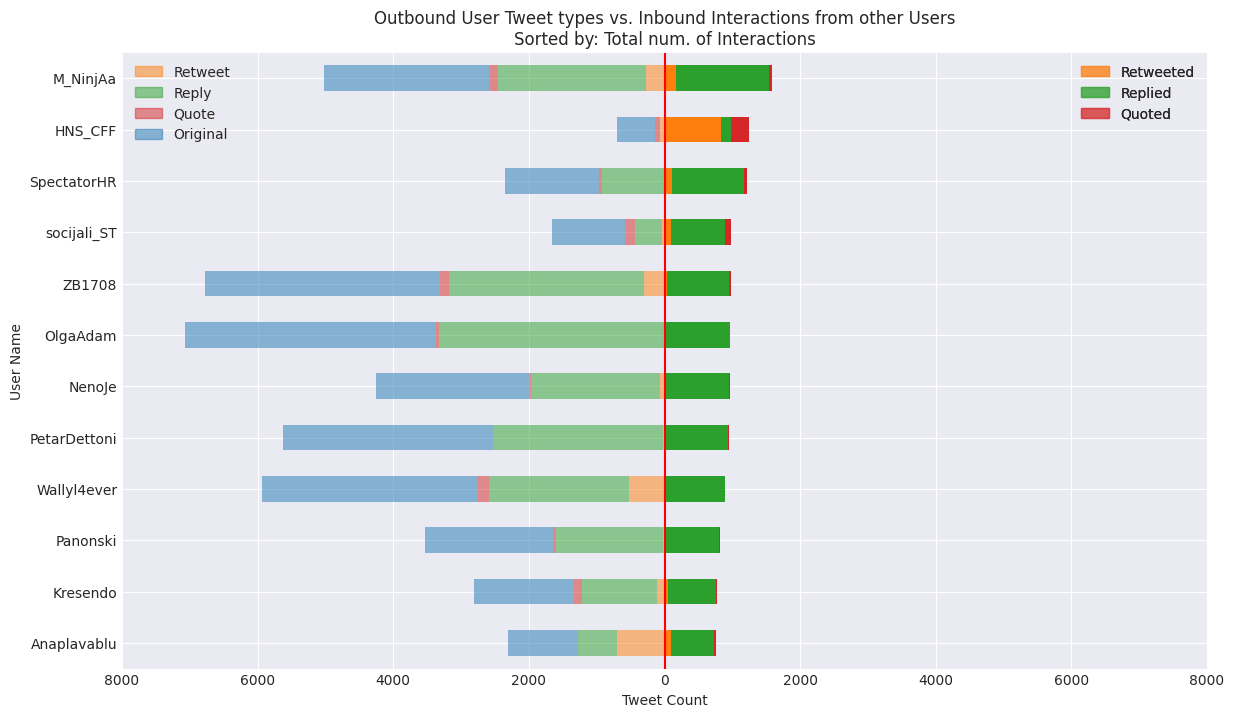

In [9]:
sorted_by = 'total_in_tweets_cnt'

top_tweeted_users = users_view.set_index(USER_DISPLAY_NAME).sort_values(by=sorted_by, ascending=False).head(PLOT_CONFIG['plot_head'])[::-1]
top_tweeted_users['max_tweets'] = top_tweeted_users.apply(lambda row: sum((row.original_tweets_cnt, row.out_retweets_cnt, row.out_replies_cnt, row.out_quotes_cnt)), axis=1)
MAX_X = top_tweeted_users['max_tweets'].max() + (top_tweeted_users['max_tweets'].max() * .1)


plot_top_tweet_users(
    top_tweeted_users, 
    title=(
        'Outbound User Tweet types '
        'vs. Inbound Interactions from other Users\n'
        'Sorted by: {}'.format(PLOT_CONFIG['other_cols'][sorted_by])
    ), 
    max_x=MAX_X,
    export_plot_name='eps/users-interaction-initiators-total.eps'
)

[WARNING] 2022-12-09 00:25:24 matplotlib.backends.backend_ps - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


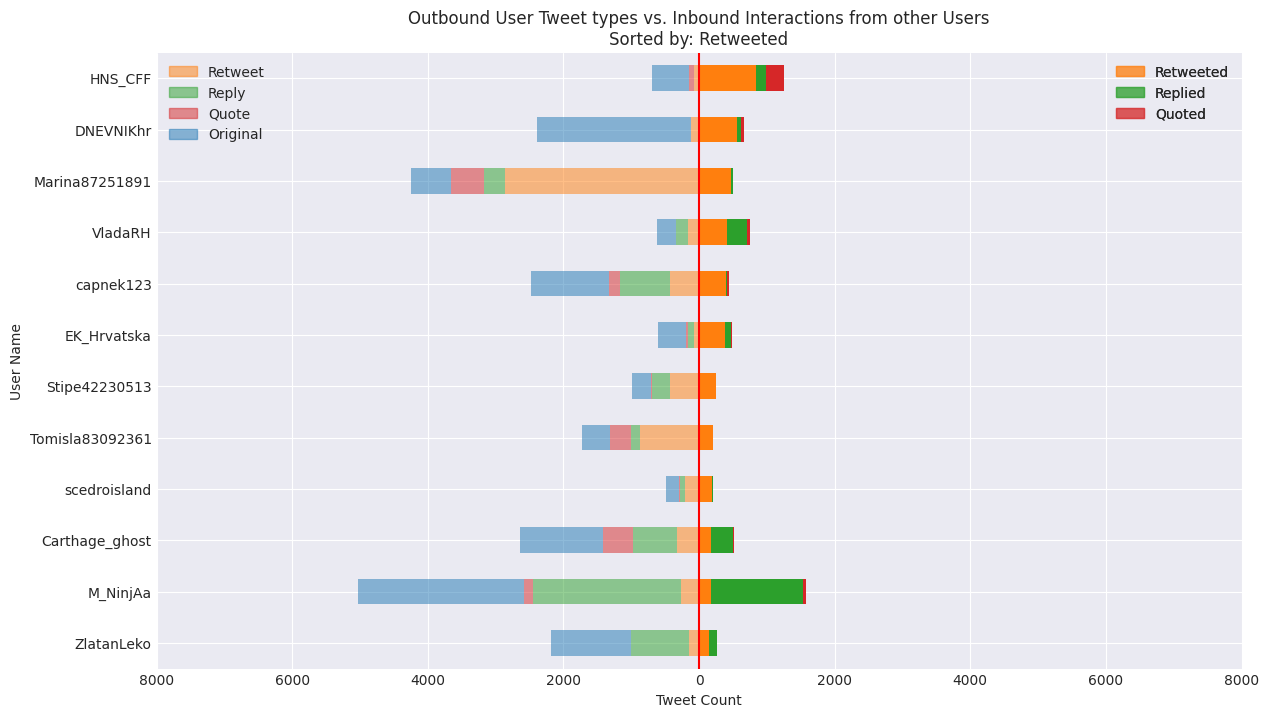

In [10]:
sorted_by = 'in_retweets_cnt'
top_retweeted_users = users_view.set_index(USER_DISPLAY_NAME).sort_values(by=sorted_by, ascending=False).head(PLOT_CONFIG['plot_head'])[::-1]
plot_top_tweet_users(
    top_retweeted_users, 
    title=(
        'Outbound User Tweet types '
        'vs. Inbound Interactions from other Users\n'
        'Sorted by: {}'
    ).format(PLOT_CONFIG['positive_cols'][sorted_by]),
    max_x=MAX_X,
    export_plot_name='eps/users-interaction-initiators-retweets.eps'
)

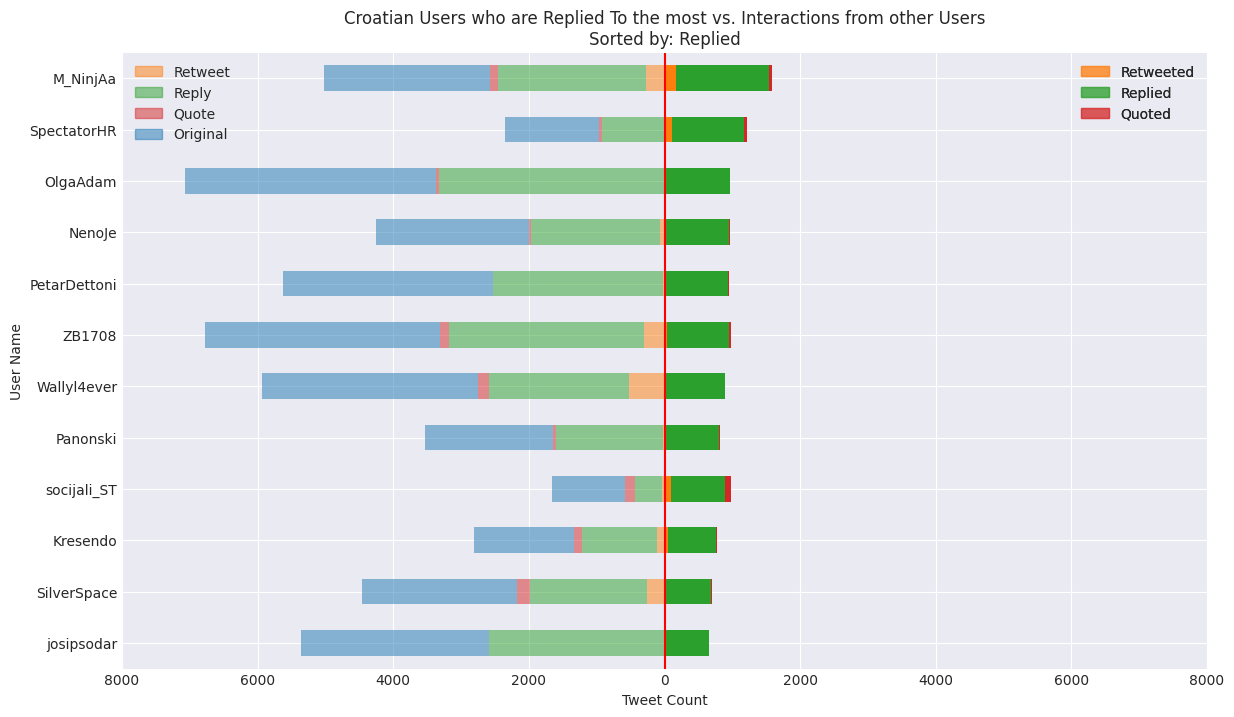

In [11]:
sorted_by = 'in_replies_cnt'
top_replied_to_users = users_view.set_index(USER_DISPLAY_NAME).sort_values(by=sorted_by, ascending=False).head(PLOT_CONFIG['plot_head'])[::-1]
plot_top_tweet_users(
    top_replied_to_users, 
    title=(
        'Croatian Users who are Replied To the most '
        'vs. Interactions from other Users\n'
        'Sorted by: {}'
    ).format(PLOT_CONFIG['positive_cols'][sorted_by]), 
    max_x=MAX_X,
    # export_plot_name='eps/users-interaction-initiators-replies.eps'
)

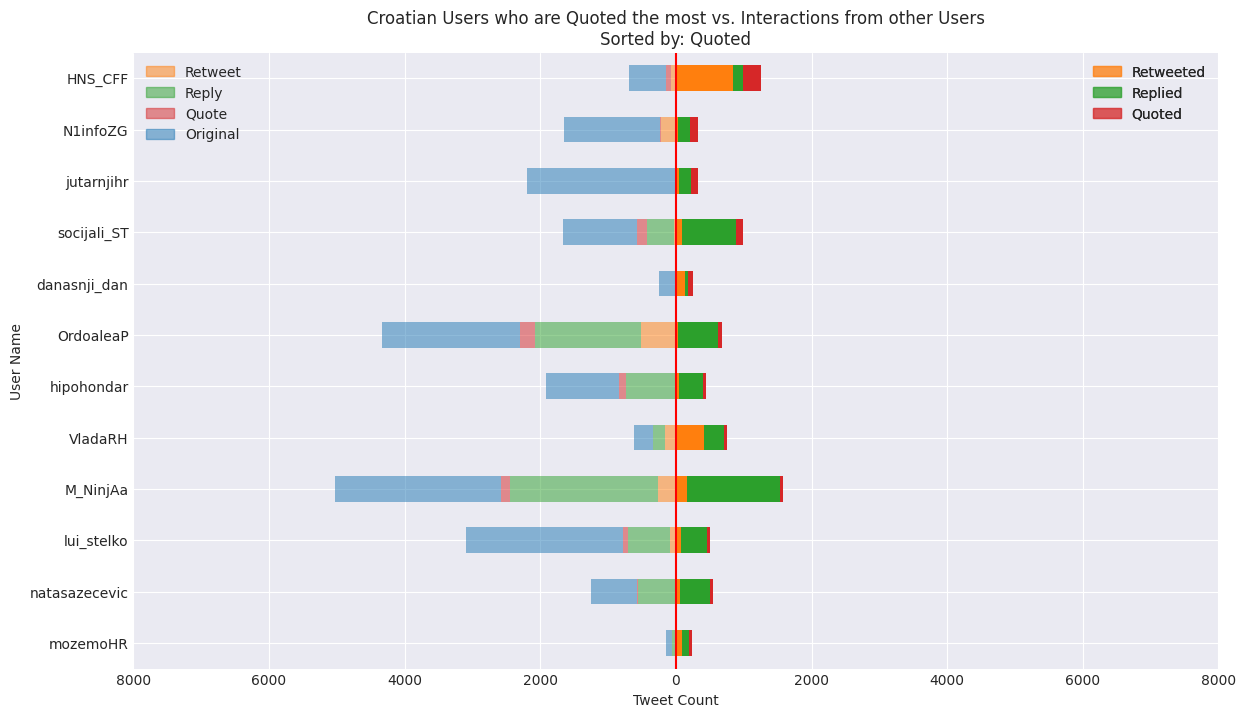

In [12]:
sorted_by = 'in_quotes_cnt'
top_quoted_users = users_view.set_index(USER_DISPLAY_NAME).sort_values(by=sorted_by, ascending=False).head(PLOT_CONFIG['plot_head'])[::-1]
plot_top_tweet_users(
    top_quoted_users, 
    title=(
        'Croatian Users who are Quoted the most '
        'vs. Interactions from other Users\n'
        'Sorted by: {}').format(PLOT_CONFIG['positive_cols'][sorted_by]), 
    max_x=MAX_X
)

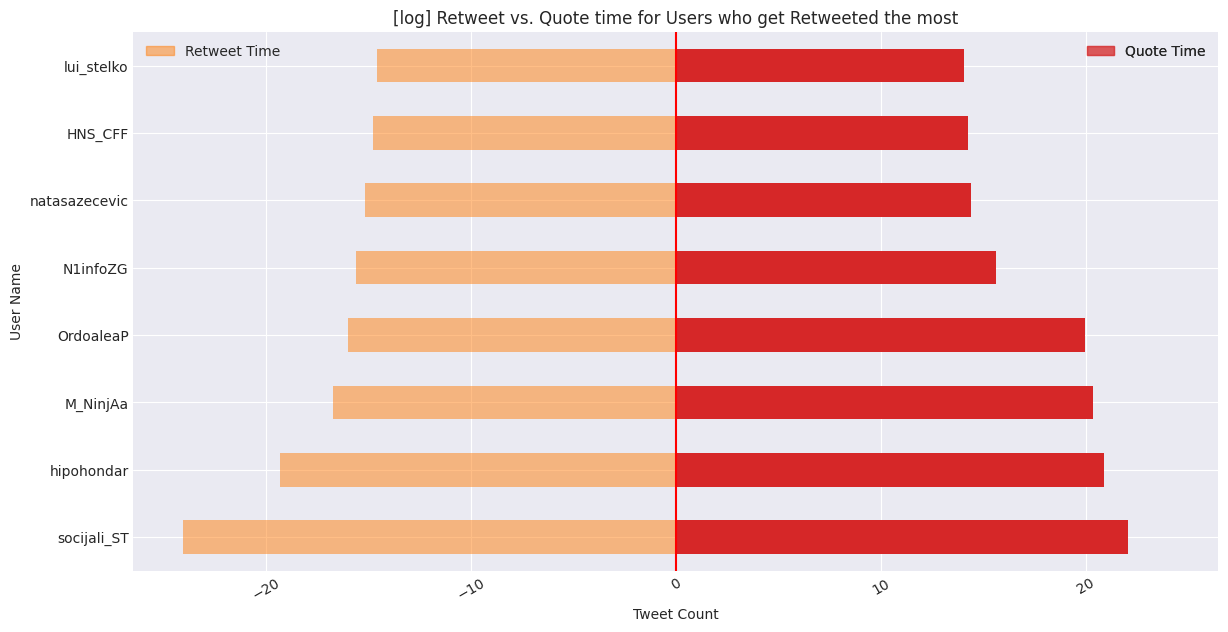

In [13]:
import numpy as np
# np.log2(fastest_retweeted_users['quote_timedelta_sec'])
fig, ax = plt.subplots(1, figsize=(14, 7))

fastest_retweeted_users = users_view.set_index(USER_DISPLAY_NAME).sort_values(by='in_retweets_cnt').tail(PLOT_CONFIG['plot_head']).sort_values('retweet_timedelta_sec')
fastest_retweeted_users = fastest_retweeted_users[['retweet_timedelta_sec']].dropna()[::-1]
fastest_retweeted_users['retweet_timedelta_sec'] = (np.log2(fastest_retweeted_users['retweet_timedelta_sec'])*-1)

fastest_quoted_users = users_view.set_index(USER_DISPLAY_NAME).sort_values(by='in_quotes_cnt').tail(PLOT_CONFIG['plot_head']).sort_values('quote_timedelta_sec')
fastest_quoted_users = fastest_quoted_users[['quote_timedelta_sec']].dropna()[::-1]
fastest_quoted_users['quote_timedelta_sec'] = np.log2(fastest_quoted_users['quote_timedelta_sec'])

fastest_retweeted_users.plot.barh(
    ax=ax, 
    alpha=0.5,
    stacked=True,
    color=default_colors[1]
)
legend_1 = plt.legend(['Retweet Time'], loc='upper left')
legend_1.legendHandles[0].set_color(default_colors[1])

fastest_quoted_users.plot.barh(ax=ax, stacked=True, color=default_colors[3])
legend_2 = plt.legend(['Quote Time'], loc='upper right')
legend_2.legendHandles[0].set_color(default_colors[3])

ax.add_artist(legend_1)
ax.add_artist(legend_2)
ax.set_title('[log] Retweet vs. Quote time for Users who get Retweeted the most')
ax.set_xlabel('Tweet Count')
ax.set_ylabel('User Name')
min_x = fastest_retweeted_users['retweet_timedelta_sec'].min() + (fastest_retweeted_users['retweet_timedelta_sec'].min() * .1)
ax.set_xlim(min_x, min_x*-1)
# ax.yaxis.set_major_formatter(lambda x, pos: f'{abs(x):g}')
ax.axvline(color='red')

plt.xticks(rotation=30)
plt.show()


In [14]:
from wordcloud import WordCloud
from math import ceil

ncols = 3
nrows = ceil(len(top_retweeted_users) / ncols)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*7, ncols*len(top_retweeted_users)), squeeze=False)

i, j = 0, 0
for screen_name in top_retweeted_users.index[::-1]:
    if j == ncols: j = 0; i += 1
    
    wordcloud_str = ' '.join(top_retweeted_users.loc[screen_name].hashtags)
    wordcloud = WordCloud(
        collocations=False, 
        background_color='white', 
        width=720, 
        height=540, 
        margin=10
    ).generate(wordcloud_str)
    
    axs[i][j].imshow(wordcloud, interpolation='bilinear')
    axs[i][j].set_title(screen_name)
    axs[i][j].axis('off')

    j += 1
plt.show()

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
users_view[['original_tweets_pct', 'out_retweets_pct', 'out_replies_pct']].plot.hist(alpha=0.5, ax=ax[0])

ax[0].set_title('Original vs Retweets vs Replies % distribution among Users')
ax[0].set_ylabel('Num. of Users')
ax[0].set_xlabel('% distribution')
ax[0].legend(['Original', 'Retweet', 'Reply'])
ax[0].set_ylim(0, 6800)

users_view[['in_retweets_cnt', 'in_replies_cnt']].plot.hist(alpha=0.5, ax=ax[1], color={'in_retweets_cnt': default_colors[1], 'in_replies_cnt': default_colors[2]})
# users_view['retweet_tweets_pct'].hist(ax=ax, log=False, color=default_colors[1])
ax[1].set_title('Retweeted vs Replied To % distribution among Users')
ax[1].set_ylabel('Num. of Users')
ax[1].set_xlabel('% distribution')
ax[1].legend(['Retweeted', 'Replied To'])

plt.show()

In [16]:
from math import ceil

title = 'Monthy ratio between outbound Original, Retweet and Reply Tweets'

upper_limit = 350_000
step_1 = 20_000
step_2 = 60_000

ncols = 3
nrows = ceil(step_2/step_1/ncols) + ceil(upper_limit/step_2/ncols)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharey=True, figsize=(ncols*8, nrows*8))

plt.suptitle(title)

i, j = 0, 0
for limit in range(0, step_2, step_1):
    if j == ncols: j = 0; i += 1
    
    users_view[
        (users_view['followers_count'] > limit)
        & (users_view['followers_count'] < limit+step_1)
    ].set_index(USER_DISPLAY_NAME).sort_values('original_tweets_cnt', ascending=False)[
        ['original_tweets_cnt', 'out_retweets_cnt', 'out_replies_cnt']
    ].head(10).rename(
        columns={
            'original_tweets_cnt': 'Original',
            'out_retweets_cnt': 'Retweet',
            'out_replies_cnt': 'Reply'
        }
    ).plot.bar(rot=30, stacked=True, ax=axs[i][j])
    axs[i][j].set_title('Users with Followers Count: {} - {}'.format(limit, limit+step_1))
    axs[i][j].set_ylabel('Tweet Count')
    axs[i][j].set_xlabel(None)
    
    j += 1

for limit in range(step_2, upper_limit, step_2):
    if j == ncols: j = 0; i += 1
    
    if limit >= upper_limit:
        step = users_view.followers_count.max()
    
    users_view[
        (users_view['followers_count'] > limit)
        & (users_view['followers_count'] < limit+step_2)
    ].set_index(USER_DISPLAY_NAME).sort_values('total_out_tweets_cnt', ascending=False)[
        ['original_tweets_cnt', 'out_retweets_cnt', 'out_replies_cnt']
    ].head(10).rename(
        columns={
            'original_tweets_cnt': 'Original',
            'out_retweets_cnt': 'Retweet',
            'out_replies_cnt': 'Reply'
        }
    ).plot.bar(rot=30, stacked=True, ax=axs[i][j])
    axs[i][j].set_title('Users with Followers Count: {} - {}'.format(limit, limit+step_2))
    axs[i][j].set_ylabel('Tweet Count')
    axs[i][j].set_xlabel(None)
    
    j += 1
plt.show()

In [17]:
from math import ceil

title = 'Monthy ratio between inbound Retweeted and Replied To Tweets'

upper_limit = 350_000
step_1 = 20_000
step_2 = 60_000

ncols = 3
nrows = ceil(step_2/step_1/ncols) + ceil(upper_limit/step_2/ncols)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharey=True, figsize=(ncols*8, nrows*8))

plt.suptitle(title)

i, j = 0, 0
for limit in range(0, step_2, step_1):
    if j == ncols: j = 0; i += 1
    
    users_view[
        (users_view['followers_count'] > limit)
        & (users_view['followers_count'] < limit+step_1)
    ].set_index(USER_DISPLAY_NAME).sort_values('total_in_tweets_cnt', ascending=False)[
        ['in_retweets_cnt', 'in_replies_cnt']
    ].head(PLOT_CONFIG['plot_head']).rename(
        columns=PLOT_CONFIG['positive_cols']
    ).plot.bar(rot=30, stacked=True, ax=axs[i][j], color={'Retweeted': default_colors[1], 'Replied': default_colors[2]})
    axs[i][j].set_title('Users with Followers Count: {} - {}'.format(limit, limit+step_1))
    axs[i][j].set_ylabel('Tweet Count')
    axs[i][j].set_xlabel(None)
    
    j += 1

for limit in range(step_2, upper_limit, step_2):
    if j == ncols: j = 0; i += 1
    
    if limit >= upper_limit:
        step = users_view.followers_count.max()
    
    users_view[
        (users_view['followers_count'] > limit)
        & (users_view['followers_count'] < limit+step_2)
    ].set_index(USER_DISPLAY_NAME).sort_values('total_in_tweets_cnt', ascending=False)[
        ['in_retweets_cnt', 'in_replies_cnt']
    ].head(PLOT_CONFIG['plot_head']).rename(
        columns=PLOT_CONFIG['positive_cols']
    ).plot.bar(rot=30, stacked=True, ax=axs[i][j], color={'Retweeted': default_colors[1], 'Replied': default_colors[2]})
    axs[i][j].set_title('Users with Followers Count: {} - {}'.format(limit, limit+step_2))
    axs[i][j].set_ylabel('Tweet Count')
    axs[i][j].set_xlabel(None)
    
    j += 1
plt.show()

In [18]:
users_view[users_view['screen_name'] == 'yugoslav_luka'].iloc[0]